In [27]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [29]:
output_path = '../output/uno_3d_8nodes_r4_g1_model2-learningRate-2/'
train_hist = np.loadtxt(os.path.join(output_path, 'training_history.csv'), delimiter=',')
ngpus = 1

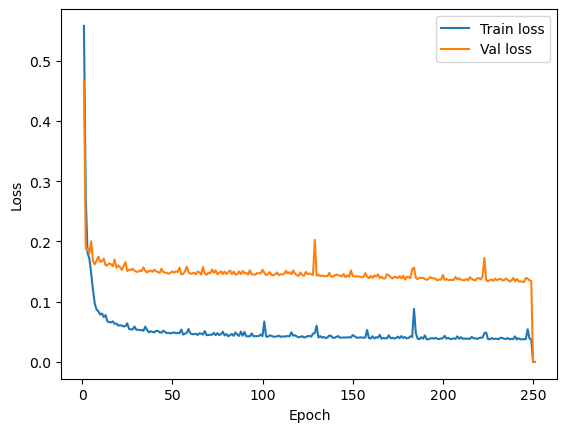

In [30]:
n_epochs = len(train_hist) + 1
plt.plot(range(1, n_epochs), train_hist[:, 0]*ngpus, label='Train loss')
plt.plot(range(1, n_epochs), train_hist[:, 1], label='Val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Reading in the data

In [31]:
def inv_scale(scaled, data_min, data_max):
    orig = scaled * (data_max - data_min) + data_min
    return orig

In [32]:
## read in the results
d = np.load(os.path.join(output_path, f'test_results.npz'))
results = inv_scale(d['results'], data_min=12.8, data_max=20.3)

In [33]:
## read in the test data
d = np.load('/p/gpfs1/kong11/data/SMART/data_assimilation_toolbox_test_data/simulation_data/normalized_training/test_data.npz')
y = inv_scale(d['test_y'], data_min=12.8, data_max=20.3)

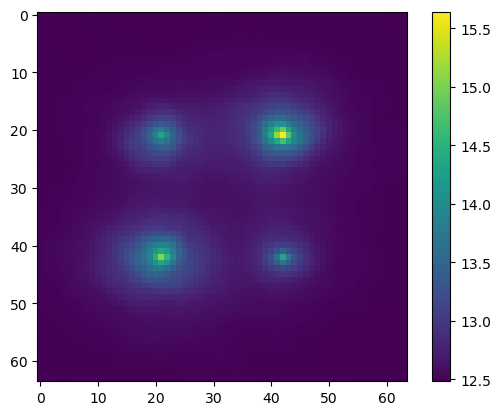

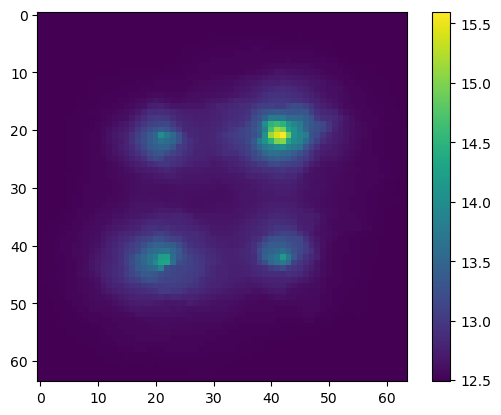

In [34]:
ix = 10
im = plt.imshow(results[ix, 0, :, :, 0, 0])
cbar = plt.colorbar(im)
plt.show()

im=plt.imshow(y[ix, :, :, 0, 0])
cbar = plt.colorbar(im)

plt.show()

## Residual plots

In [35]:
l2_loss = lambda diff, y: np.linalg.norm(diff, 2) / np.linalg.norm(y, 2)

/g/g92/kong11/workspace/opence/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


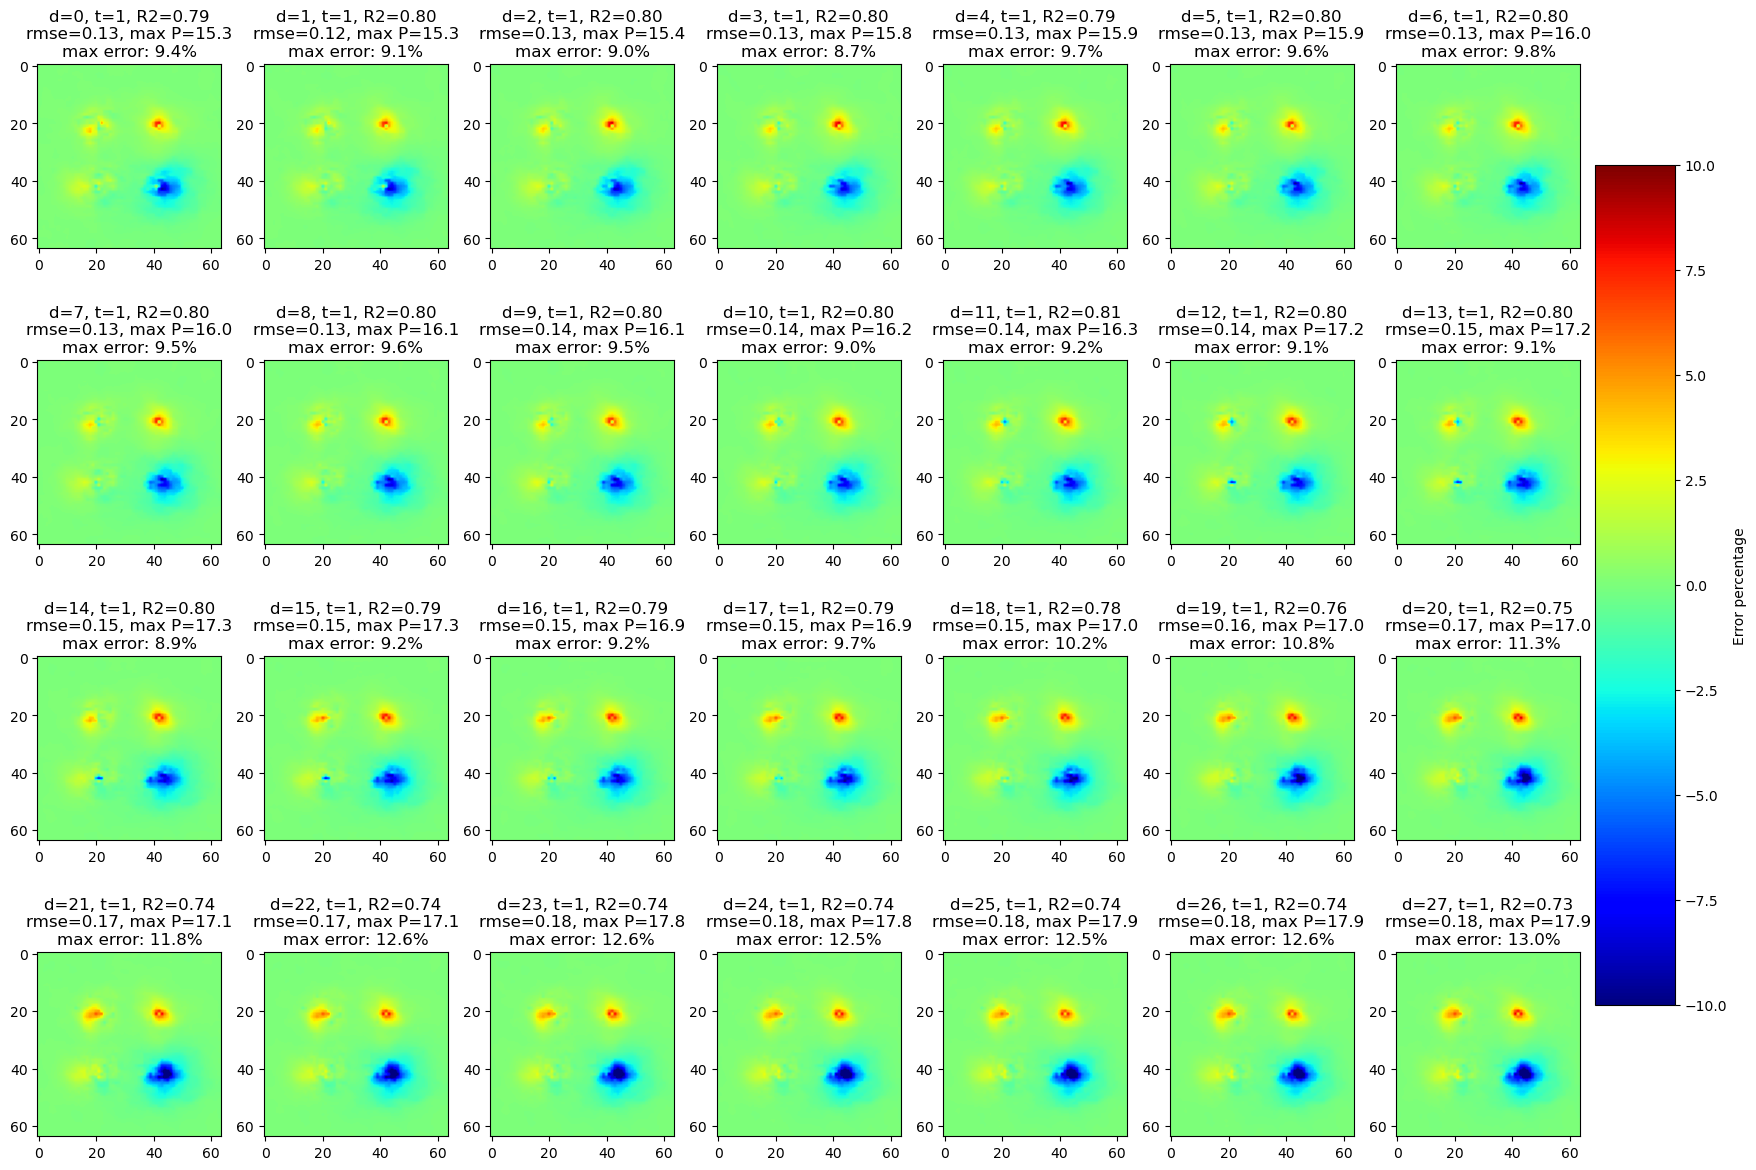

In [36]:
ix = 30
time_ix = ix%10 + 1
fig = plt.figure(figsize=(16, 12))
for i in range(28):
    plt.subplot(4, 7, i+1)
    pred_y = results[ix, 0, :, :, i, 0]
    test_y = y[ix, :, :, i, 0]
    res = pred_y - test_y
    l2 = l2_loss(res, test_y)
    y_max = test_y.max()
    if (i == 0) & (ix%10==0):
        y_max_all = y_max
    
    im = plt.imshow(res/test_y*100, cmap=plt.cm.jet, vmin=-10, vmax=10)
    mp_err = np.abs((res/test_y)).max()
    r_square = r2_score(test_y.flatten(), pred_y.flatten())
    rmse = np.sqrt(np.mean((test_y.flatten() - pred_y.flatten())**2))
    plt.title(f"d={i}, t={time_ix}, R2={r_square:.2f}\nrmse={rmse:.2f}, max P={y_max:.1f}\nmax error: {mp_err*100:.1f}%")
cbar_ax = fig.add_axes([1.0, 0.15, 0.05, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Error percentage')

plt.tight_layout()
plt.show()

/g/g92/kong11/workspace/opence/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


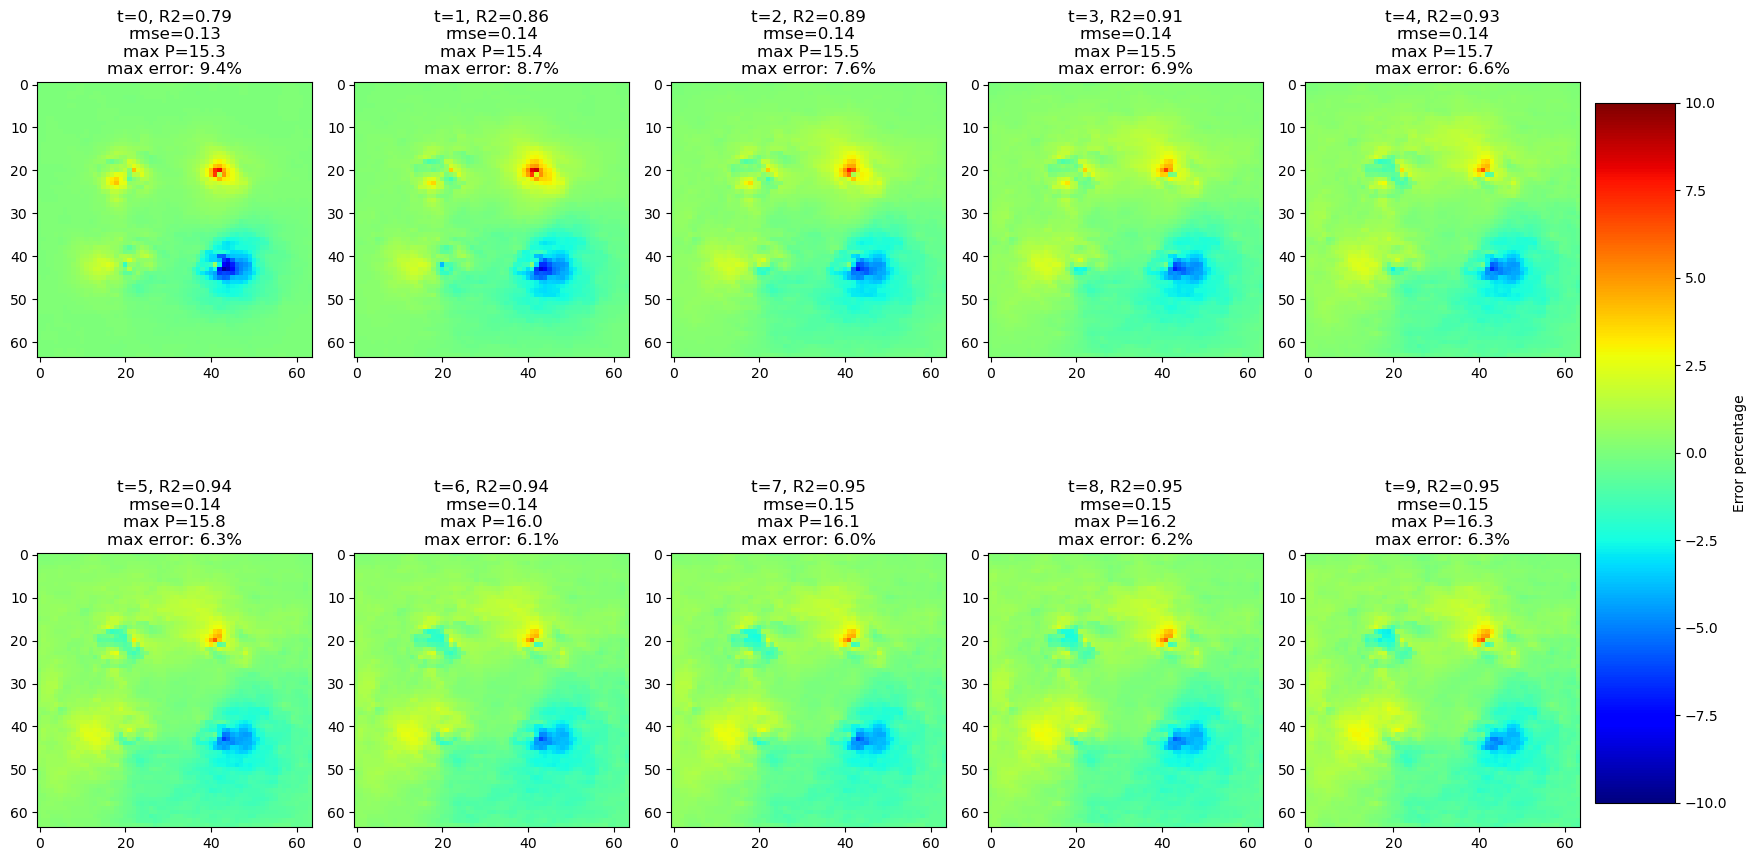

In [37]:
fig = plt.figure(figsize=(16, 10))
for i in range(10):
    time_ix = ix%10 + i
    plt.subplot(2, 5, i+1)
    pred_y = results[ix+i, 0, :, :, 0, 0]
    test_y = y[ix+i, :, :, 0, 0]
    res = pred_y - test_y
    err_max = np.amax(res)
    y_max = test_y.max()
    if (i == 0) & (ix%10==0):
        y_max_all = y_max
    
    im = plt.imshow(res/test_y*100, cmap=plt.cm.jet, vmin=-10, vmax=10)
    
    r_square = r2_score(test_y.flatten(), pred_y.flatten())
    rmse = np.sqrt(np.mean((test_y.flatten() - pred_y.flatten())**2))
    mp_err = np.abs((res/test_y)).max()
    plt.title(f"t={time_ix}, R2={r_square:.2f}\nrmse={rmse:.2f}\nmax P={y_max:.1f}\nmax error: {mp_err*100:.1f}%")
cbar_ax = fig.add_axes([1.0, 0.15, 0.05, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Error percentage')

plt.tight_layout()
plt.show()

## put all the metrics into array

In [38]:
all_results = np.zeros((int(len(y)/10), 10, 28, 6))

In [39]:
for i in range(len(y)):
    n = int(i / 10)
    for j in range(28):
        test_y = y[i, :, :, j, 0]
        pred_y = results[i, 0, :, :, j, 0]
        res = pred_y - test_y
        err_max = np.amax(res)
        err_pct = res/test_y
        max_pct_err = np.amax(err_pct)
        y_max = test_y.max()
        r_square = r2_score(test_y.flatten(), pred_y.flatten())
        rmse = np.sqrt(np.mean((test_y.flatten() - pred_y.flatten())**2))
        all_results[n, i%10, j, 0] = err_max
        all_results[n, i%10, j, 1] = y_max
        all_results[n, i%10, j, 2] = pred_y.max()
        all_results[n, i%10, j, 3] = r_square
        all_results[n, i%10, j, 4] = rmse
        all_results[n, i%10, j, 5] = max_pct_err

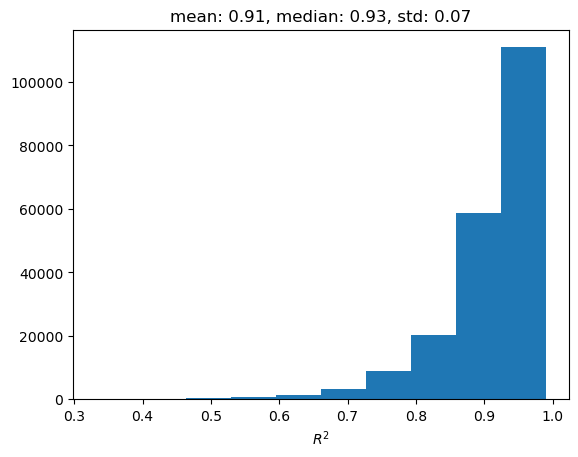

In [40]:
r2 = all_results[:, :, :, 3].flatten()
plt.hist(r2)
plt.xlabel(f'$R^2$')
plt.title(f"mean: {np.mean(r2):.2f}, median: {np.median(r2):.2f}, std: {np.std(r2):.2f}")
plt.show()

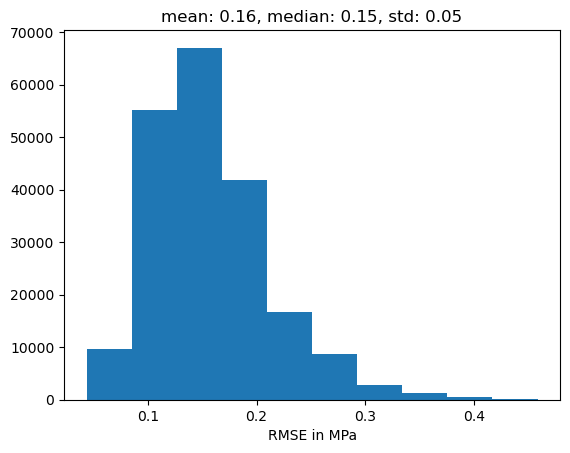

In [41]:
rmse = all_results[:, :, :, 4].flatten()

plt.hist(rmse)
plt.title(f"mean: {np.mean(rmse):.2f}, median: {np.median(rmse):.2f}, std: {np.std(rmse):.2f}")
plt.xlabel(f'RMSE in MPa')
plt.show()

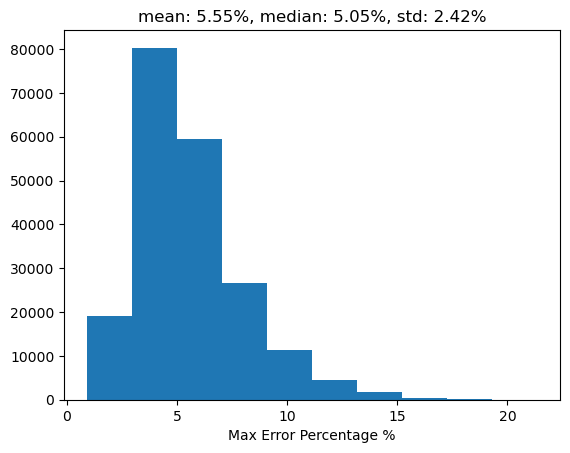

In [42]:
mp_err = all_results[:, :, :, 5].flatten() * 100

plt.hist(mp_err)
plt.title(f"mean: {np.mean(mp_err):.2f}%, median: {np.median(mp_err):.2f}%, std: {np.std(mp_err):.2f}%")
plt.xlabel(f'Max Error Percentage %')
plt.show()

### Metrics with years

In [43]:
R2_metrics = []
RMSE_metrics = []
mp_err_metrics = []
for year in range(10):
    data = all_results[:, year, :, 3].flatten()
    R2_metrics.append([np.mean(data), np.median(data), np.std(data)])
    data = all_results[:, year, :, 4].flatten()
    RMSE_metrics.append([np.mean(data), np.median(data), np.std(data)])
    data = all_results[:, year, :, 5].flatten()
    mp_err_metrics.append([np.mean(data), np.median(data), np.std(data)])
    
R2_metrics = np.array(R2_metrics)
RMSE_metrics = np.array(RMSE_metrics)
mp_err_metrics = np.array(mp_err_metrics)

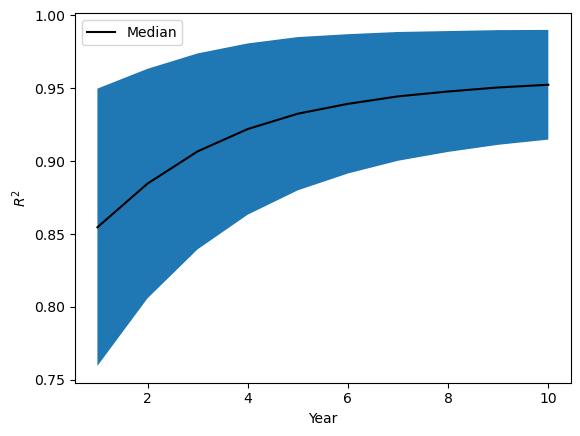

In [44]:
plt.plot(range(1, 11), R2_metrics[:, 1], 'k-', label='Median')
plt.fill_between(range(1, 11), R2_metrics[:, 1]-R2_metrics[:, -1], R2_metrics[:, 1]+R2_metrics[:, -1])
plt.ylabel(f'$R^2$')
plt.xlabel(f'Year')
plt.legend(loc=2)
plt.show()

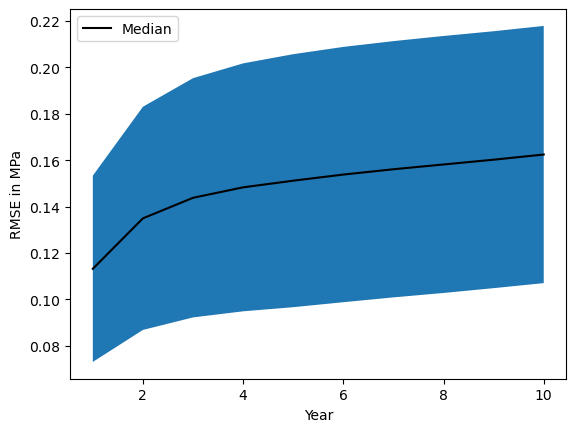

In [45]:
plt.plot(range(1, 11), RMSE_metrics[:, 1], 'k-', label='Median')
plt.fill_between(range(1, 11), RMSE_metrics[:, 1]-RMSE_metrics[:, -1], RMSE_metrics[:, 1]+RMSE_metrics[:, -1])
plt.ylabel(f'RMSE in MPa')
plt.xlabel(f'Year')
plt.legend(loc=2)
plt.show()

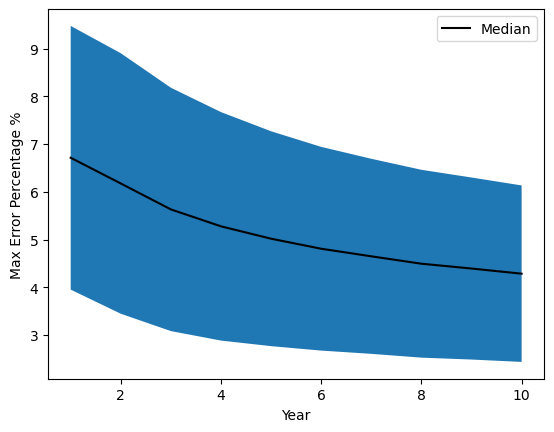

In [46]:
plt.plot(range(1, 11), mp_err_metrics[:, 1]*100, 'k-', label='Median')
plt.fill_between(range(1, 11), mp_err_metrics[:, 1]*100-mp_err_metrics[:, -1]*100, mp_err_metrics[:, 1]*100+mp_err_metrics[:, -1]*100)
plt.ylabel(f'Max Error Percentage %')
plt.xlabel(f'Year')
plt.legend(loc=1)
plt.show()

### Metrics with depth

In [47]:
R2_metrics_depth = []
RMSE_metrics_depth = []
for depth in range(28):
    data = all_results[:, :, depth, 3].flatten()
    R2_metrics_depth.append([np.mean(data), np.median(data), np.std(data)])
    data = all_results[:, :, depth, 4].flatten()
    RMSE_metrics_depth.append([np.mean(data), np.median(data), np.std(data)])
    
R2_metrics_depth = np.array(R2_metrics_depth)
RMSE_metrics_depth = np.array(RMSE_metrics_depth)

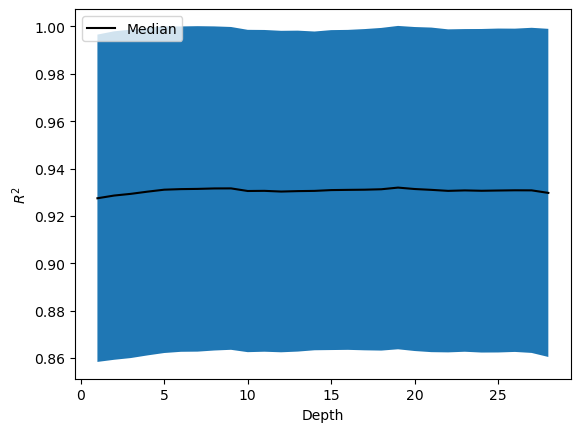

In [48]:
plt.plot(range(1, 29), R2_metrics_depth[:, 1], 'k-', label='Median')
plt.fill_between(range(1, 29), R2_metrics_depth[:, 1]-R2_metrics_depth[:, -1], R2_metrics_depth[:, 1]+R2_metrics_depth[:, -1])
plt.ylabel(f'$R^2$')
plt.xlabel(f'Depth')
plt.legend(loc=2)
plt.show()

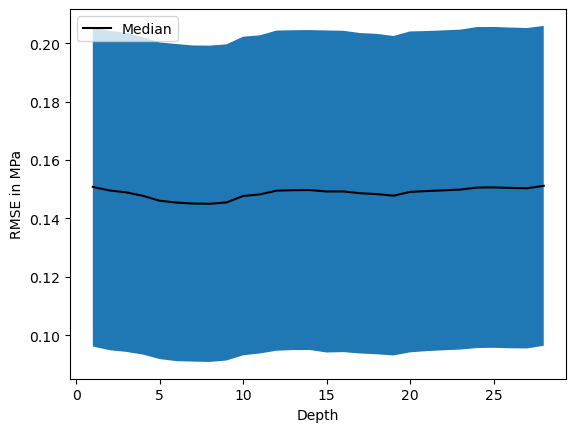

In [49]:
plt.plot(range(1, 29), RMSE_metrics_depth[:, 1], 'k-', label='Median')
plt.fill_between(range(1, 29), RMSE_metrics_depth[:, 1]-RMSE_metrics_depth[:, -1], RMSE_metrics_depth[:, 1]+RMSE_metrics_depth[:, -1])
plt.ylabel(f'RMSE in MPa')
plt.xlabel(f'Depth')
plt.legend(loc=2)
plt.show()

In [50]:
from shutil import copy

In [51]:
copy('./visualize_test_results.ipynb', output_path)

'../output/uno_3d_8nodes_r4_g1_model2-learningRate-2/visualize_test_results.ipynb'